In [2]:
#import
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from functools import partial
import pandas
import networkx as nx
import numpy as np
import geopandas as gpd
import shapely
from scipy.stats.stats import pearsonr

In [3]:
#load the dual graph
graph = Graph.from_file("./PA_VTD/PA_VTD.shp")
gdf = gpd.read_file("./PA_VTD/PA_VTD.shp")
#elections and updaters
pop_col = "TOT_POP"
election_names = [
    "PRES12",
    "PRES16",
    "SENW101216",
]
election_columns = [
    ["PRES12D", "PRES12R"],
    ["T16PRESD", "T16PRESR"],
    ["W101216D", "W101216R"],
]
updaters1 = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
updaters1.update(election_updaters)
#fix some strings which should be numbers
for n in graph.nodes():
    graph.nodes[n]['538CPCT__1'] = int(graph.nodes[n]['538CPCT__1'])
    graph.nodes[n]['538DEM_PL'] = int(graph.nodes[n]['538DEM_PL'])
    graph.nodes[n]['538GOP_PL'] = int(graph.nodes[n]['538GOP_PL'])
    graph.nodes[n]['8THGRADE_1'] = int(graph.nodes[n]['8THGRADE_1'])
#real partitions
partition_2011 = Partition(graph, "2011_PLA_1", updaters1)
partition_GOV = Partition(graph, "GOV", updaters1)
partition_TS = Partition(graph, "TS", updaters1)
partition_REMEDIAL = Partition(graph, "REMEDIAL_P", updaters1)
partition_CPCT = Partition(graph, "538CPCT__1", updaters1)
partition_DEM = Partition(graph, "538DEM_PL", updaters1)
partition_GOP = Partition(graph, "538GOP_PL", updaters1)
partition_8th = Partition(graph, "8THGRADE_1", updaters1)
partition_list = [
    partition_2011, partition_GOV, partition_TS, partition_REMEDIAL, partition_CPCT, partition_DEM, partition_GOP, partition_8th]
label_list = [
    '2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT','DEM', 'GOP','8th']
ideal_population = sum(partition_2011["population"].values())/len(partition_2011)
print("Ideal population: ", ideal_population)

Ideal population:  704718.2777777778


In [4]:
print(graph.nodes[0])
ccol = 'COUNTYFP10'

{'boundary_node': False, 'area': 58376433.4607846, 'STATEFP10': '42', 'COUNTYFP10': '039', 'VTDST10': '60', 'GEOID10': '42039060', 'VTDI10': 'A', 'NAME10': 'CAMBRIDGE SPRINGS Voting District', 'NAMELSAD10': 'CAMBRIDGE SPRINGS Voting District', 'LSAD10': '00', 'MTFCC10': 'G5240', 'FUNCSTAT10': 'N', 'ALAND10': 2258229, 'AWATER10': 0, 'INTPTLAT10': '+41.8018353', 'INTPTLON10': '-080.0596566', 'ATG12D': 0.0, 'ATG12R': 0.0, 'GOV10D': 0.0, 'GOV10R': 0.0, 'PRES12D': 0.0, 'PRES12O': 0.0, 'PRES12R': 0.0, 'SEN10D': 0.0, 'SEN10R': 0.0, 'T16ATGD': 0.0, 'T16ATGR': 0.0, 'T16PRESD': 0.0, 'T16PRESOTH': 0.0, 'T16PRESR': 0.0, 'T16SEND': 0.0, 'T16SENR': 0.0, 'USS12D': 0.0, 'USS12R': 0.0, 'GOV': 3, 'TS': 5, 'HISP_POP': 0, 'TOT_POP': 0, 'WHITE_POP': 0, 'BLACK_POP': 0, 'NATIVE_POP': 0, 'ASIAN_POP': 0, 'F2014GOVD': 0, 'F2014GOVR': 0, '2011_PLA_1': 3, 'REMEDIAL_P': 14, '538CPCT__1': 3, '538DEM_PL': 3, '538GOP_PL': 3, '8THGRADE_1': 1, 'geometry': <shapely.geometry.polygon.Polygon object at 0x120275ac8>}


In [5]:
def county_intersections(part, ccol):
    county_intersections = {}
    for n in graph.nodes():
        county = graph.nodes[n][ccol]
        if county not in county_intersections:
            county_intersections[county] = set([part.assignment[n]])
        county_intersections[county].update([part.assignment[n]])
    return county_intersections   
        

In [6]:
def naked_boundary(part, ccol):
    graph = part.graph
    ce_non_cboundary = 0
    for (a,b) in part["cut_edges"]:
        if graph.nodes[a][ccol] == graph.nodes[b][ccol]:
            ce_non_cboundary += 1
    return ce_non_cboundary

In [7]:
def coincident_boundary_by_d(part, ccol):
    graph = part.graph
    ce = {d:0 for d in part.parts}
    ce_on_cboundary = {d:0 for d in part.parts}
    for (a,b) in part["cut_edges"]:
        ce[part.assignment[a]] += 1
        ce[part.assignment[b]] += 1
        if graph.nodes[a][ccol] != graph.nodes[b][ccol]:
            ce_on_cboundary[part.assignment[a]] += 1
            ce_on_cboundary[part.assignment[b]] += 1
    return {d: ce_on_cboundary[d]/ce[d] for d in part.parts}

In [8]:
def pieces(part, ccol):
    county_intersections = {}
    for n in graph.nodes():
        county = graph.nodes[n][ccol]
        if county not in county_intersections:
            county_intersections[county] = set([part.assignment[n]])
        county_intersections[county].update([part.assignment[n]])
    pieces = 0
    for county in county_intersections:
        for d in county_intersections[county]:
            subgraph = graph.subgraph(
                [x for x in part.parts[d] if graph.nodes[x][ccol] == county]
            )
            pieces += nx.number_connected_components(subgraph)
    return pieces

2011 41
GOV 22
TS 20
REMEDIAL 18
CPCT 17
DEM 47
GOP 32
8th 62


Text(0, 0.5, 'parts')

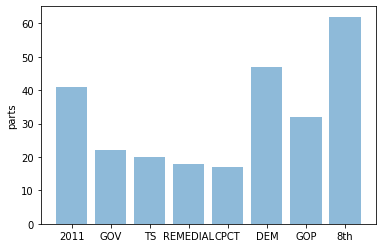

In [9]:
csplits = []
for index, part in enumerate(partition_list):
    ci = county_intersections(part, ccol)
    csplits.append(sum([len(x) for x in ci.values()])-len(ci))
    print(label_list[index], csplits[index])
y_pos = np.arange(len(label_list))
plt.bar(y_pos, csplits, align='center', alpha=0.5)
plt.xticks(y_pos, label_list)
plt.ylabel('parts')

2011 112
GOV 89
TS 88
REMEDIAL 85
CPCT 84
DEM 117
GOP 106
8th 138


Text(0, 0.5, 'pieces')

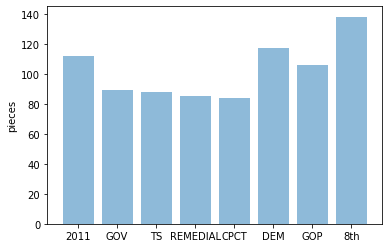

In [10]:
csplits = []
for index, part in enumerate(partition_list):
    csplits.append(pieces(part,ccol))
    print(label_list[index], csplits[index])
y_pos = np.arange(len(label_list))
plt.bar(y_pos, csplits, align='center', alpha=0.5)
plt.xticks(y_pos, label_list)
plt.ylabel('pieces')

005 9
061 10
081 5
2011 4
---
005 9
061 11
081 5
117 5
097 10
GOV 0
---
005 9
TS 1
---
061 10
REMEDIAL 0
---
005 9
CPCT 0
---
061 10
097 11
033 5
027 9
103 17
DEM 3
---
005 9
009 11
061 9
GOP 7
---
047 1
047 6
017 4
079 5
067 10
099 11
035 5
131 3
071 8
103 3
8th 9
---


Text(0, 0.5, 'pieces - parts')

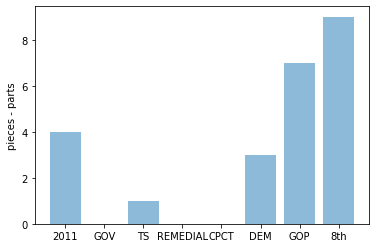

In [11]:
csplits = []
for index, part in enumerate(partition_list):
    ci = county_intersections(part, ccol)
    ###
    for c in ci:
        for d in ci[c]:
            if len([x for x in graph.nodes if graph.nodes[x][ccol] == c and part.assignment[x] == d]) < 3:
                print(c,d)
    ###
    
    csplits.append(pieces(part,ccol)-sum([len(x) for x in ci.values()]))
    print(label_list[index], csplits[index])
    print("---")

y_pos = np.arange(len(label_list))
plt.bar(y_pos, csplits, align='center', alpha=0.5)
plt.xticks(y_pos, label_list)
plt.ylabel('pieces - parts')

Text(0, 0.5, 'max split')

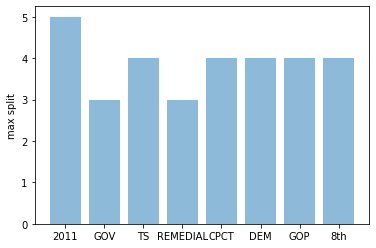

In [12]:
cmax = []
for index, part in enumerate(partition_list):
    ci = county_intersections(part, ccol)
    cmax.append(max([len(x) for x in ci.values()]))
y_pos = np.arange(len(label_list))
plt.bar(y_pos, cmax, align='center', alpha=0.5)
plt.xticks(y_pos, label_list)
plt.ylabel('max split')

Text(0, 0.5, 'naked boundary')

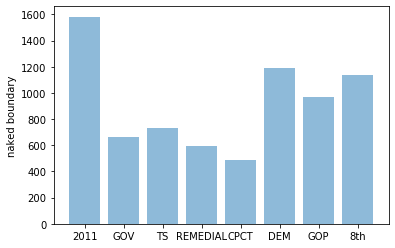

In [13]:
nboundary = []
for index, part in enumerate(partition_list):
    nboundary.append(naked_boundary(part,ccol))
y_pos = np.arange(len(label_list))
plt.bar(y_pos, nboundary, align='center', alpha=0.5)
plt.xticks(y_pos, label_list)
plt.ylabel('naked boundary')


In [14]:
gdfc = gdf.dissolve(by=ccol)
gdfc["centers"] = gdfc.geometry.centroid

2011 :


<Figure size 432x288 with 0 Axes>

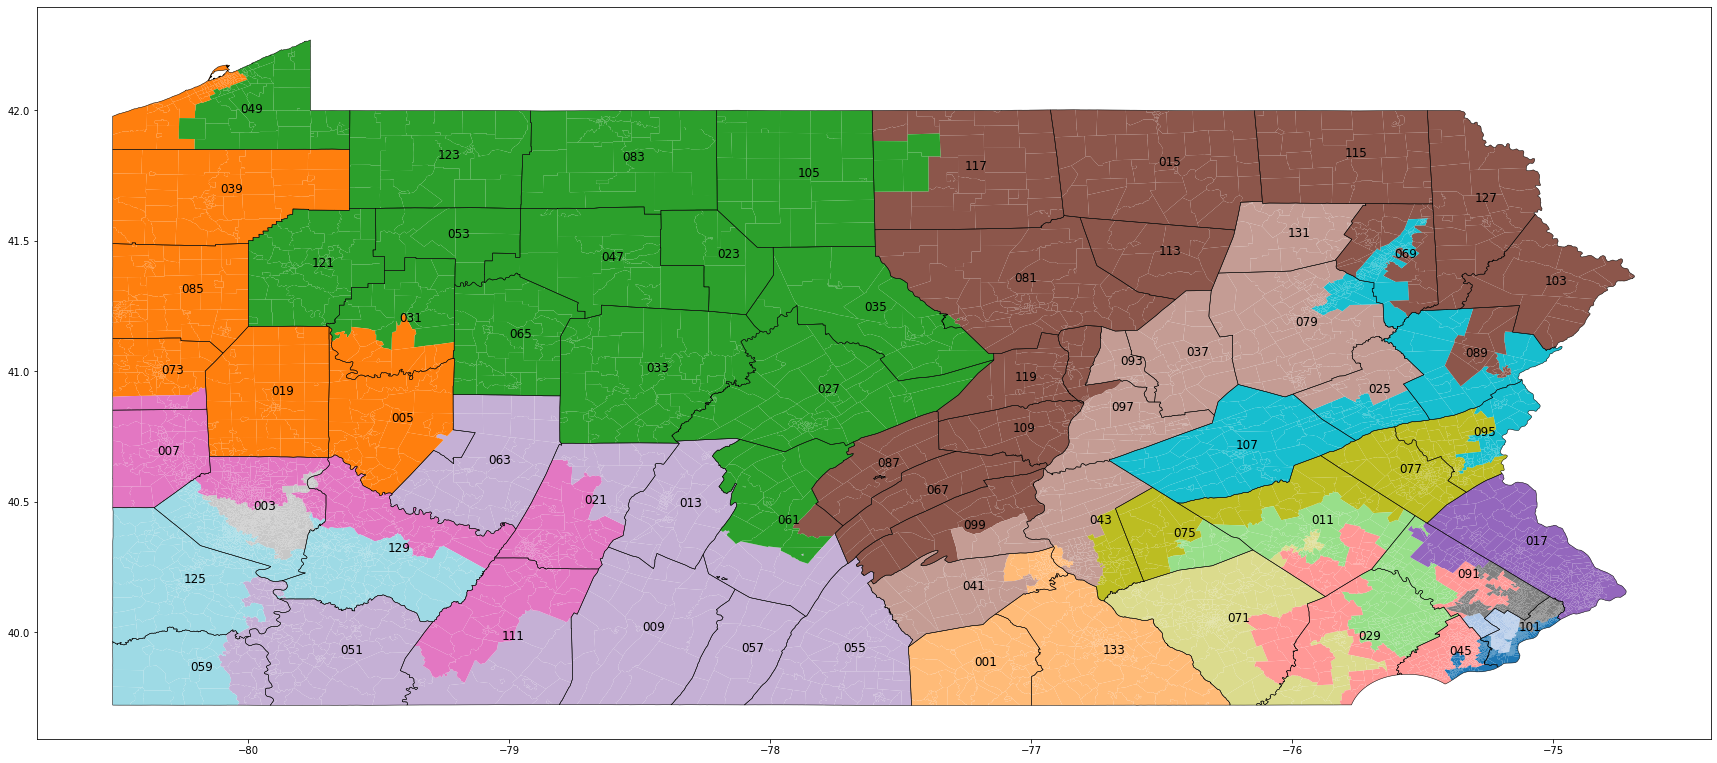

GOV :


<Figure size 432x288 with 0 Axes>

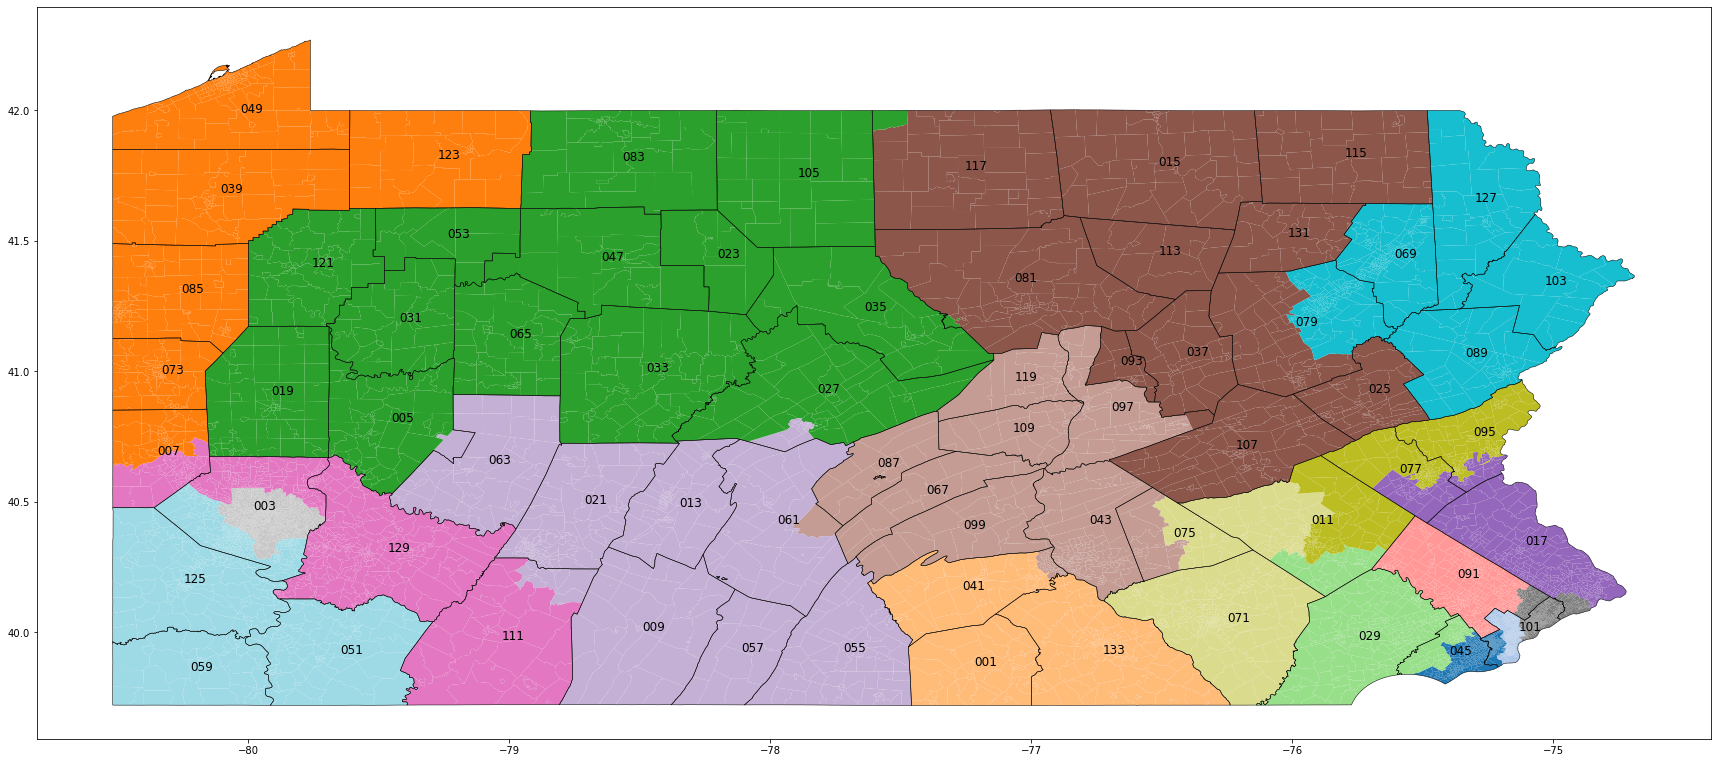

TS :


<Figure size 432x288 with 0 Axes>

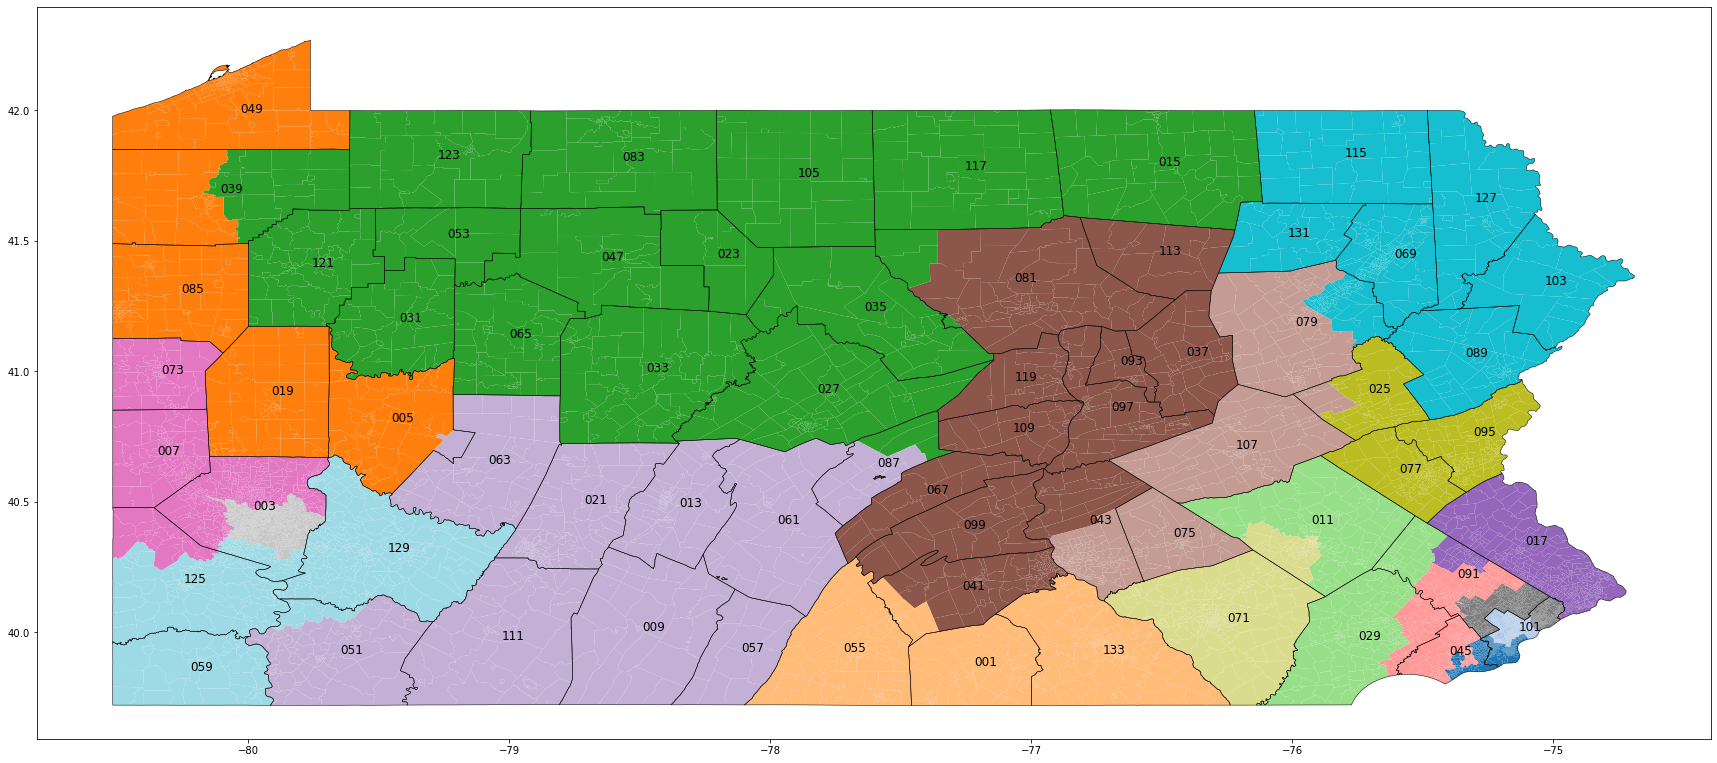

REMEDIAL :


<Figure size 432x288 with 0 Axes>

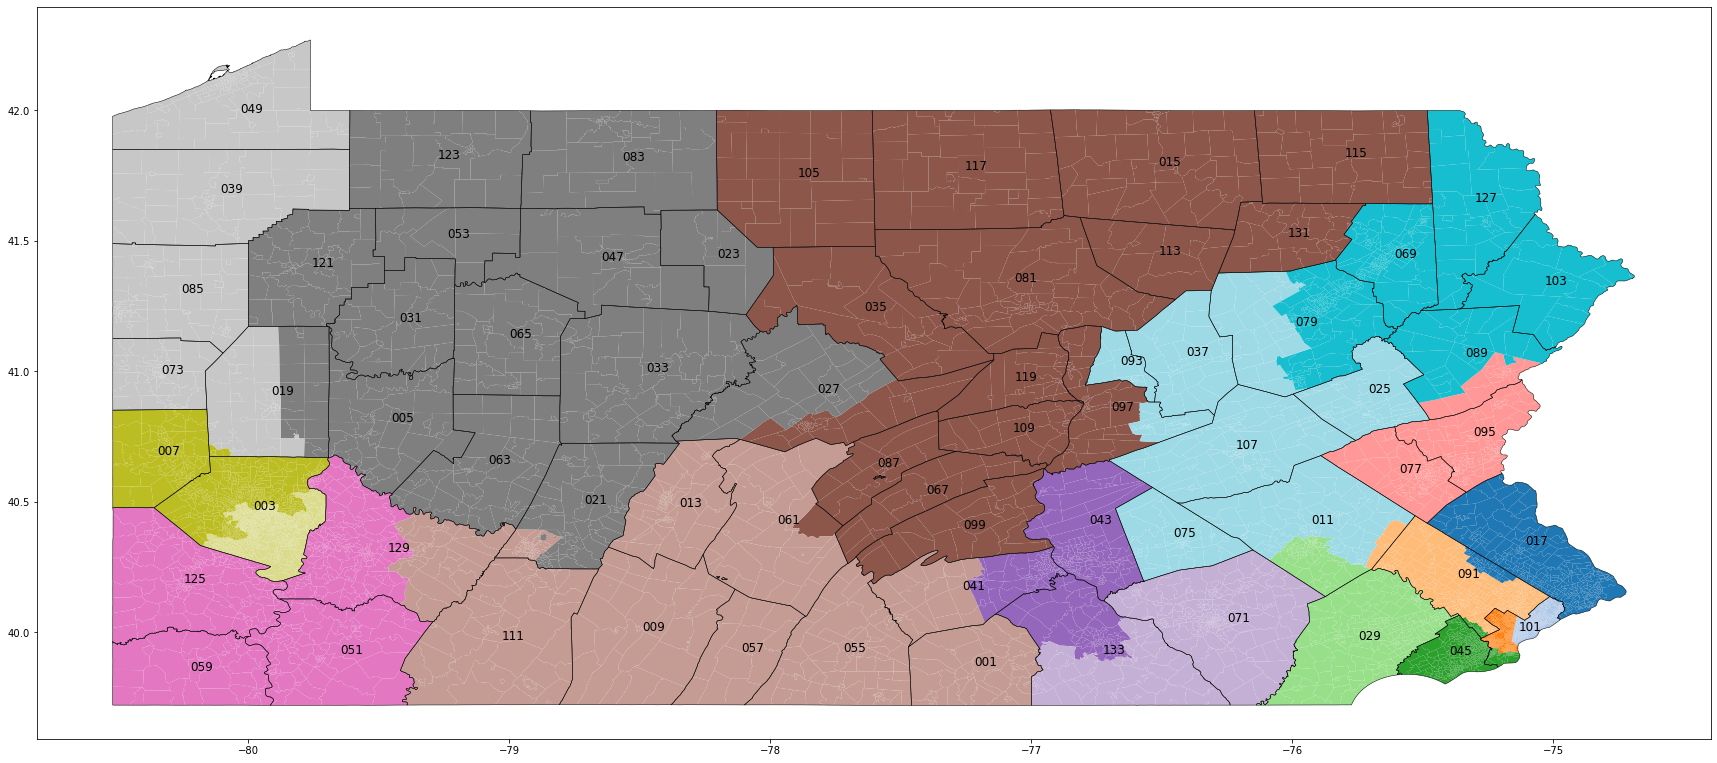

CPCT :


<Figure size 432x288 with 0 Axes>

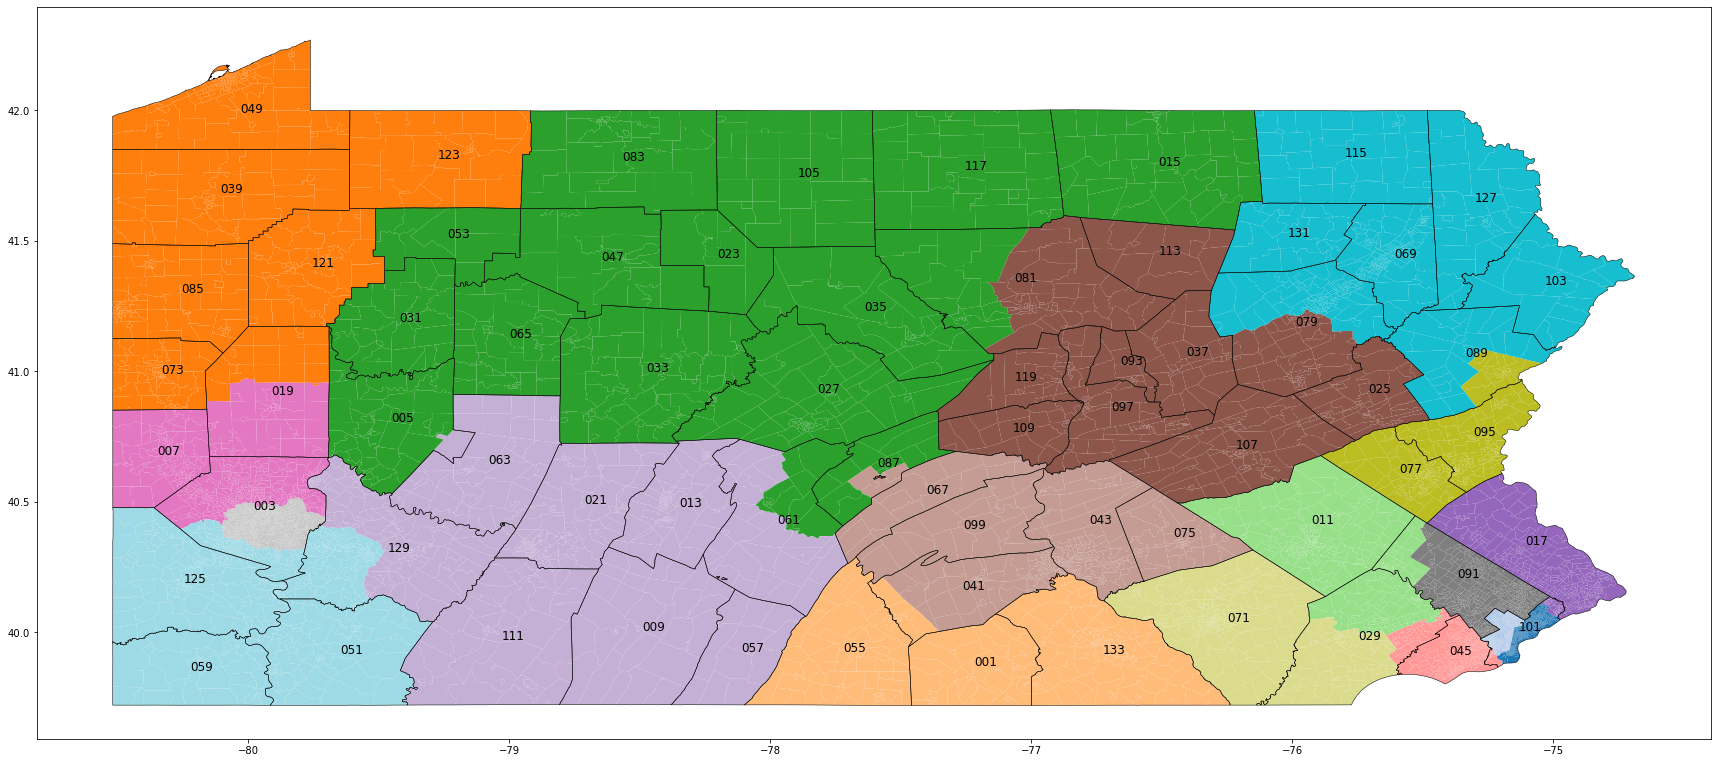

DEM :


<Figure size 432x288 with 0 Axes>

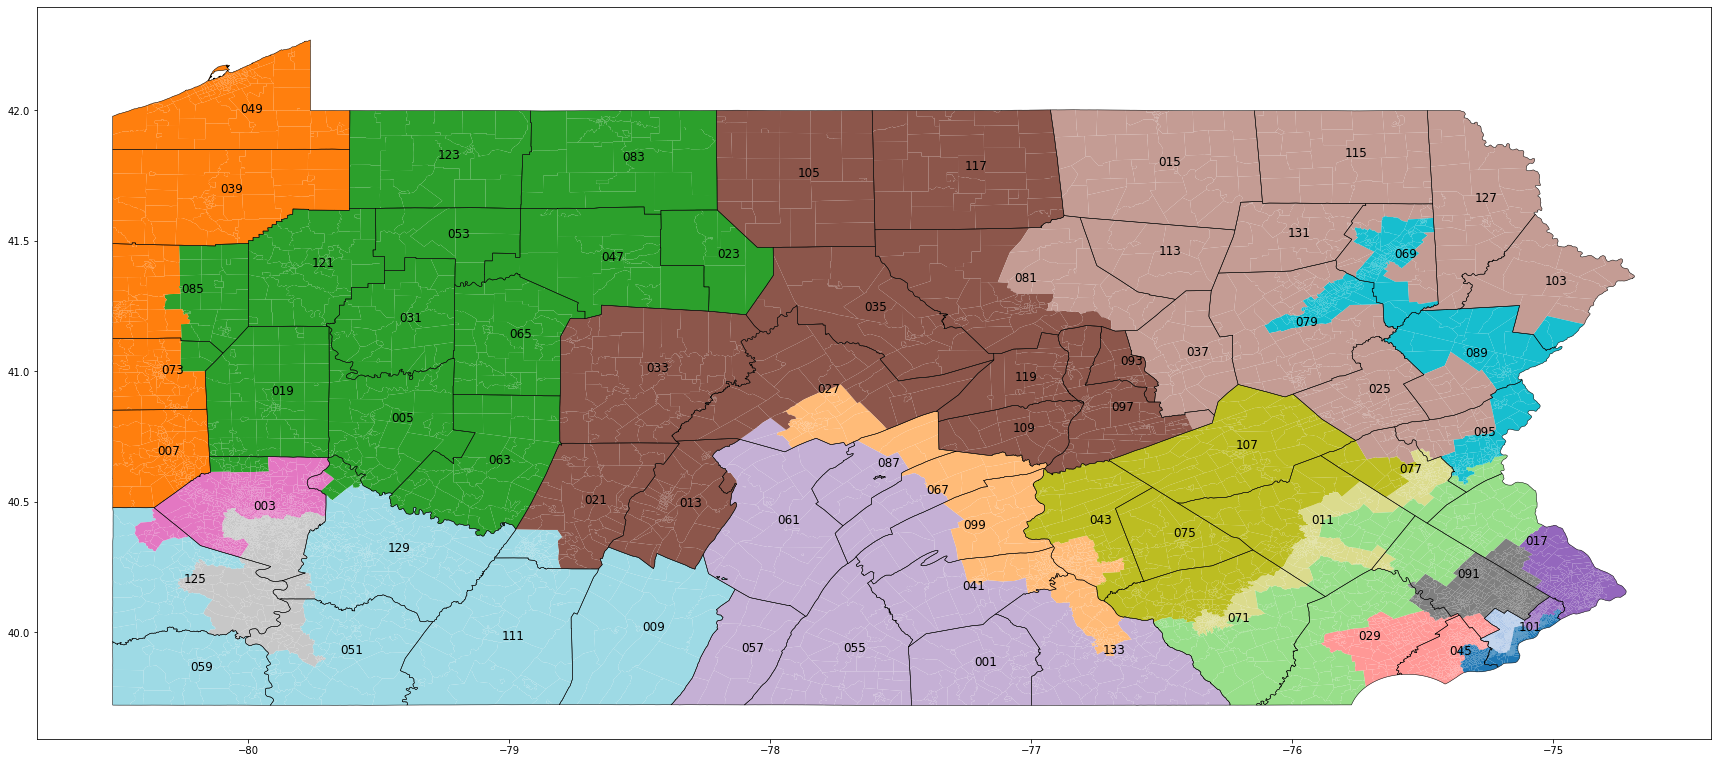

GOP :


<Figure size 432x288 with 0 Axes>

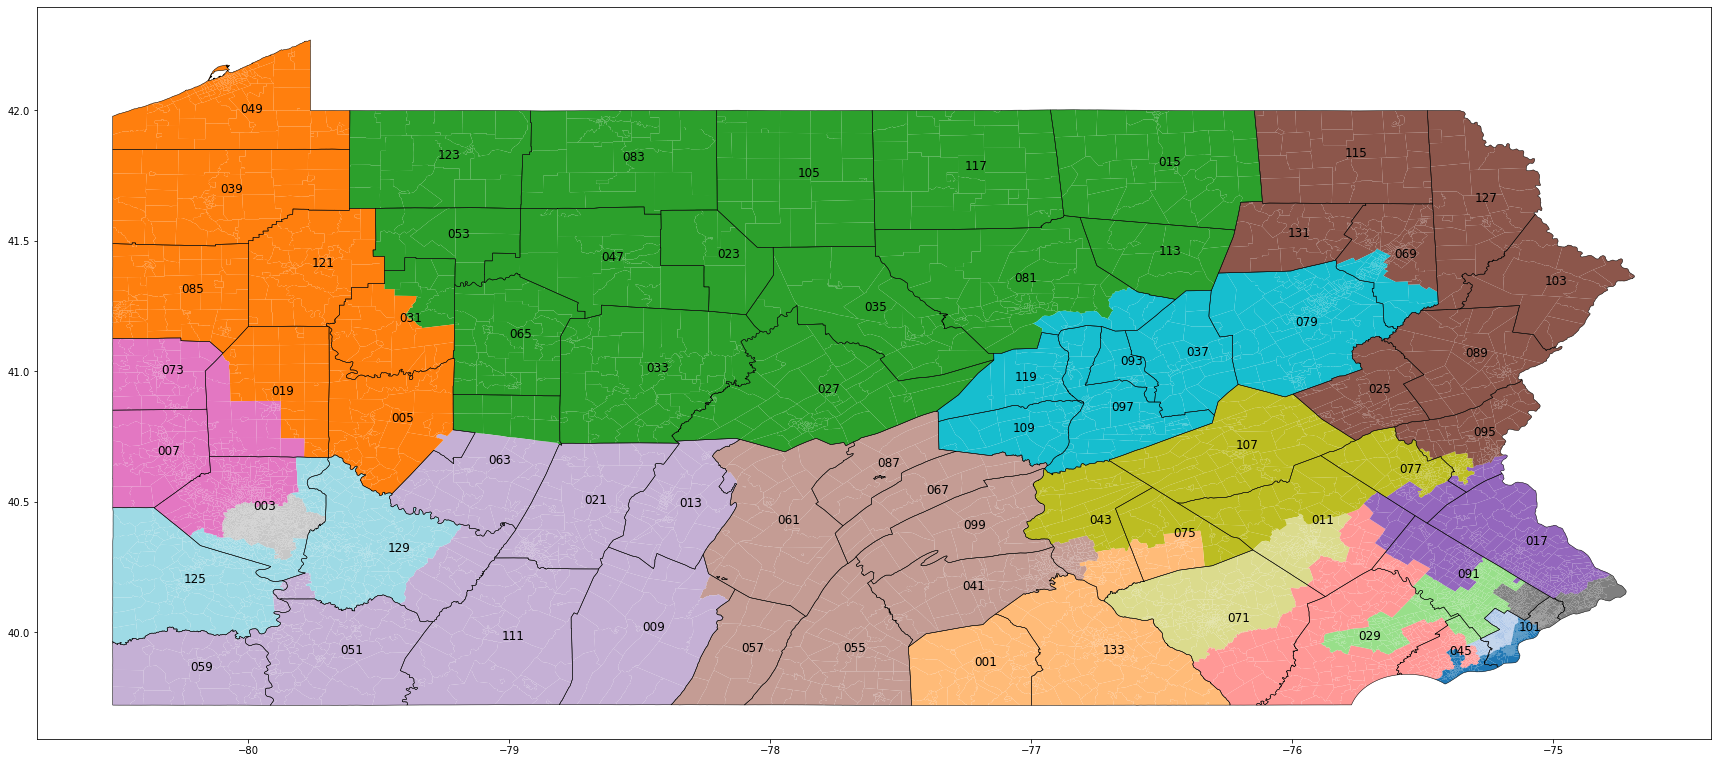

8th :


<Figure size 432x288 with 0 Axes>

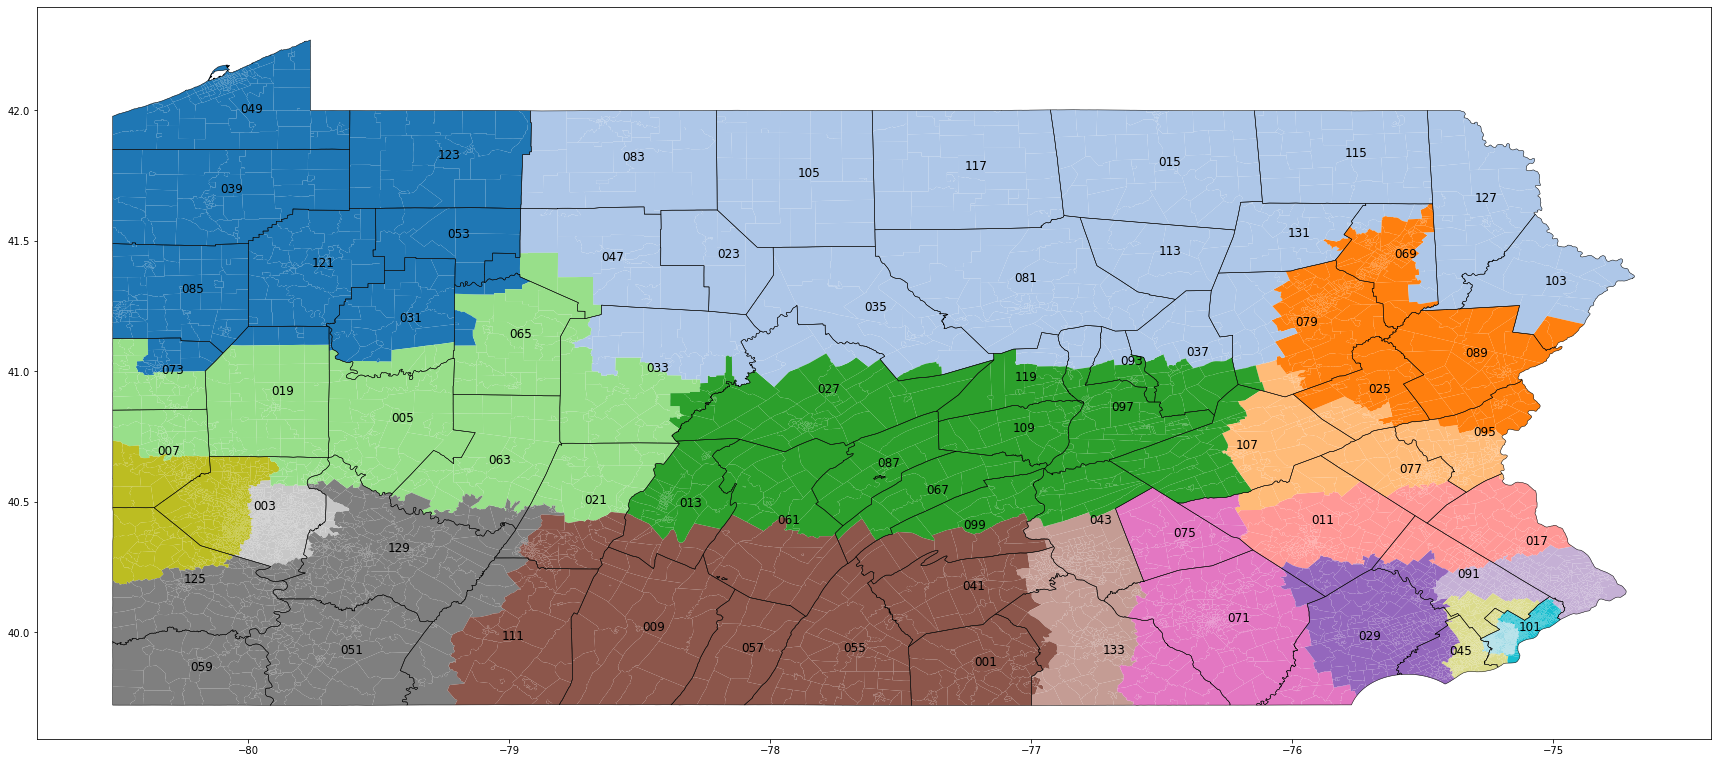

In [15]:
for index, part in enumerate(partition_list):
    assignment_series = part.assignment.to_series()
    gdf["assignment"] = assignment_series
    plt.figure()
    axes = gdfc.boundary.plot(figsize=(30,20), color=None, edgecolor="black", linewidth=0.5)
    gdf.plot(column="assignment", cmap='tab20', ax=axes)
    labelmap = gdfc.copy()
    labelmap.set_geometry("centers", inplace=True)
    texts=[]
    for x,y,label in zip(labelmap.geometry.x, labelmap.geometry.y, labelmap.index):
        texts.append(plt.text(x,y,str(label), fontsize=12))
    print(label_list[index], ":")
    plt.savefig(label_list[index]+"_counties.png")
    plt.show()

In [ ]:
gdfc